In [1]:
%matplotlib inline

In [49]:
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

In [3]:
from scipy.stats import beta
from itertools import product

In [4]:
x = np.linspace(0,1, 100)

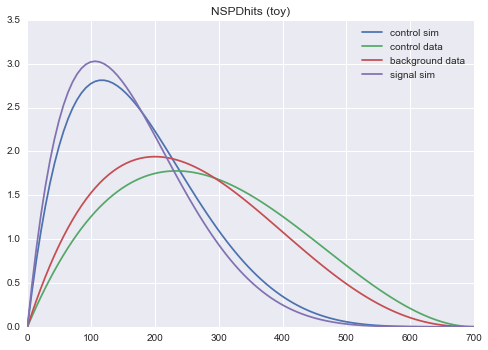

In [5]:
plt.plot(x*700, beta.pdf(x, 2,6), label="control sim")
plt.plot(x*700, beta.pdf(x, 2,3), label="control data")

plt.plot(x*700, beta.pdf(x, 2,3.5), label="background data")
plt.plot(x*700, beta.pdf(x, 2,6.6), label="signal sim")

plt.title("NSPDhits (toy)")
plt.legend(loc='best')

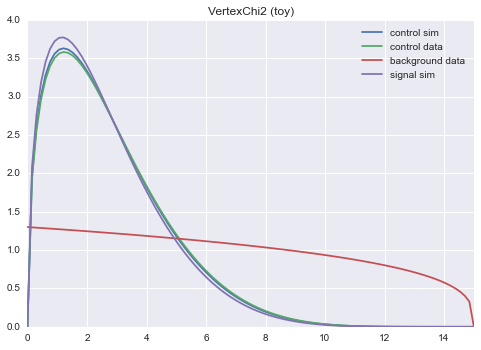

In [7]:
plt.plot(x*15, beta.pdf(x, 1.5,6.7), label="control sim")
plt.plot(x*15, beta.pdf(x, 1.5,6.6), label="control data")

plt.plot(x*15, beta.pdf(x, 1.,1.3), label="background data")
plt.plot(x*15, beta.pdf(x, 1.5,7.), label="signal sim")

plt.xlim([0.,15])
plt.title("VertexChi2 (toy)")
plt.legend(loc='best')

In [64]:
n_samples = 10000
Xs = {}
parameters = {"control sim": ((2,6), (1.5,6.7)),
              "control data": ((2,3), (1.5,6.6)),
              "background data": ((2,3.5), (1.,1.3)),
              "signal sim": ((2,6.6), (1.5,7.)),
              "signal data": ((2,3.3), (1.5,6.7)),
             }

parameters = {"control sim": ((2,3.7), (1.5,6.7)),
              "control data": ((2,3.2), (1.5,6.6)),
              
              "background data": ((2,3.5), (1.,1.3)),
              
              "signal sim": ((2,3.8), (1.5,7.)),
              "signal data": ((2,3.3), (1.5,6.7)),
             }

for category in parameters.keys():
    Xs[category] = 0
    
    p_spd, p_vtx = parameters[category]
    nspd = 800 * beta(*p_spd).rvs(n_samples)
    vertexchi2 = 15 * beta(*p_vtx).rvs(n_samples)
    X = np.vstack((nspd, vertexchi2)).T
    Xs[category] = X

In [60]:
def build_dataset(categoryA, categoryB):
    X = np.concatenate((Xs[categoryA], Xs[categoryB]))
    y = np.concatenate((np.zeros(n_samples), np.ones(n_samples)))
    return X,y

In [32]:
def compute_ks(pred_sim, pred_data):
    y = np.concatenate((np.ones(len(pred_sim)), np.zeros(len(pred_data))))
    pred = np.concatenate((pred_sim, pred_data))
    fpr, tpr, _ = roc_curve(y, pred)
    return np.max(np.abs(fpr - tpr))

Agreement check: 0.071 < 0.09


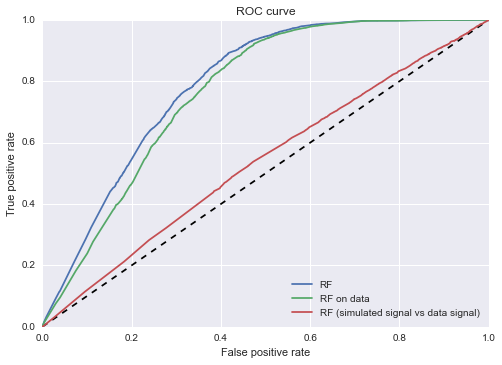

In [83]:
X_data,y_data = build_dataset("background data", "signal data")

X,y = build_dataset("background data", "signal sim")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=498)

rf = RandomForestClassifier(n_estimators=30, max_depth=3, random_state=6423+1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

y_pred_data = rf.predict_proba(X_data)[:, 1]
fpr_data, tpr_data, _ = roc_curve(y_data, y_pred_data)

X_sigsig,y_sigsig = build_dataset("signal data", "signal sim")
y_pred_sigsig = rf.predict_proba(X_sigsig)[:, 1]
fpr_sigsig, tpr_sigsig, _ = roc_curve(y_sigsig, y_pred_sigsig)


print "Agreement check: %.3f < 0.09"%compute_ks(rf.predict_proba(Xs['control sim'])[:, 1],
                                                rf.predict_proba(Xs['control data'])[:, 1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_data, tpr_data, label='RF on data')
plt.plot(fpr_sigsig, tpr_sigsig, label='RF (simulated signal vs data signal)')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')